In [18]:
import os
from pathlib import Path

PROJECT_ROOT = Path(os.getcwd()).parent
os.chdir(PROJECT_ROOT)

print("Working directory set to:", Path.cwd())

import sys
from pathlib import Path

# Detect project root (folder that contains 'src')
cwd = Path.cwd()

if (cwd / "src").exists():
    PROJECT_ROOT = cwd
elif (cwd.parent / "src").exists():
    PROJECT_ROOT = cwd.parent
else:
    raise RuntimeError("Cannot find project root containing 'src' folder")

sys.path.insert(0, str(PROJECT_ROOT))

print("Project root set to:", PROJECT_ROOT)
print("sys.path[0]:", sys.path[0])
print("Project contents:", [p.name for p in PROJECT_ROOT.iterdir()])


Working directory set to: c:\Users\sprin\OneDrive\Desktop\breast_ cancer_ml
Project root set to: c:\Users\sprin\OneDrive\Desktop\breast_ cancer_ml
sys.path[0]: c:\Users\sprin\OneDrive\Desktop\breast_ cancer_ml
Project contents: ['data', 'experiments', 'figures', 'notebooks', 'reports', 'src']


In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from src.utils import load_dataset
from src.datasets import encode_target, select_base_features
from src.features import add_irregularity_index
from src.models import get_logistic_model

print("Imports successful")


Imports successful


In [4]:
df = load_dataset("data/breast_cancer_wisconsin.csv")
df = encode_target(df)
df = select_base_features(df)
df = add_irregularity_index(df)

df.head()


,concavity_mean,perimeter_mean,radius_mean,area_mean,target,irregularity_index
0,0.3001,122.80,17.99,1001.0,1,0.000020
1,0.0869,132.90,20.57,1326.0,1,0.000005
2,0.1974,130.00,19.69,1203.0,1,0.000012
3,0.2414,77.58,11.42,386.1,1,0.000040
4,0.1980,135.10,20.29,1297.0,1,0.000011


In [6]:
df["size_bucket"] = pd.qcut(
    df["area_mean"],
    q=3,
    labels=["Small", "Medium", "Large"]
)

df["size_bucket"].value_counts()


size_bucket
Small     190
Large     190
Medium    189
Name: count, dtype: int64

In [10]:
X = df[
    [
        "concavity_mean",
        "perimeter_mean",
        "radius_mean",
        "area_mean",
    ]
]

y = df["target"]

X_train, X_test, y_train, y_test, size_train, size_test = train_test_split(
    X,
    y,
    df["size_bucket"],
    test_size=0.3,
    random_state=42,
    stratify=y
)

model = get_logistic_model()
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]


In [11]:
def entropy(p):
    eps = 1e-9
    return -(p * np.log(p + eps) + (1 - p) * np.log(1 - p + eps))


In [12]:
entropy_vals = entropy(y_prob)
confidence_margin = np.abs(y_prob - 0.5)


In [13]:
df_uncertainty = pd.DataFrame({
    "y_true": y_test.values,
    "y_prob": y_prob,
    "entropy": entropy_vals,
    "confidence_margin": confidence_margin,
    "size_bucket": size_test.values
})

df_uncertainty.head()


,y_true,y_prob,entropy,confidence_margin,size_bucket
0,0,0.393561,0.670314,0.106439,Medium
1,0,0.038411,0.162860,0.461589,Small
2,0,0.007170,0.042547,0.492830,Small
3,0,0.036327,0.156089,0.463673,Small
4,0,0.098124,0.320941,0.401876,Medium


In [14]:
df_uncertainty.groupby("size_bucket")[["entropy", "confidence_margin"]].agg(["mean", "std"])


C:\Users\sprin\AppData\Local\Temp\ipykernel_35712\1606523437.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_uncertainty.groupby("size_bucket")[["entropy", "confidence_margin"]].agg(["mean", "std"])


entropy           confidence_margin          
                 mean       std              mean       std
size_bucket                                                
Small        0.167121  0.069595          0.458272  0.023048
Medium       0.432380  0.153291          0.317791  0.115666
Large        0.216986  0.266256          0.395499  0.154367

In [15]:
df_uncertainty["y_pred"] = (df_uncertainty["y_prob"] >= 0.5).astype(int)
df_uncertainty["error"] = df_uncertainty["y_pred"] != df_uncertainty["y_true"]

df_uncertainty.groupby(["size_bucket", "error"])["entropy"].mean()


C:\Users\sprin\AppData\Local\Temp\ipykernel_35712\3956177949.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_uncertainty.groupby(["size_bucket", "error"])["entropy"].mean()


size_bucket  error
Small        False    0.167121
             True          NaN
Medium       False    0.384028
             True     0.580891
Large        False    0.184258
             True     0.650634
Name: entropy, dtype: float64

In [19]:
import json
from pathlib import Path

EXPERIMENTS_DIR = Path("experiments")
EXPERIMENTS_DIR.mkdir(exist_ok=True)

results = (
    df_uncertainty
    .groupby("size_bucket")[["entropy", "confidence_margin"]]
    .mean()
    .to_dict()
)

with open(EXPERIMENTS_DIR / "h5_results.json", "w") as f:
    json.dump(results, f, indent=2)

print("Saved:", EXPERIMENTS_DIR / "h5_results.json")


Saved: experiments\h5_results.json


C:\Users\sprin\AppData\Local\Temp\ipykernel_35712\3015922315.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("size_bucket")[["entropy", "confidence_margin"]]


In [21]:
from pathlib import Path
import matplotlib.pyplot as plt

FIGURES_DIR = Path("figures")
FIGURES_DIR.mkdir(exist_ok=True)


<Figure size 600x400 with 0 Axes>

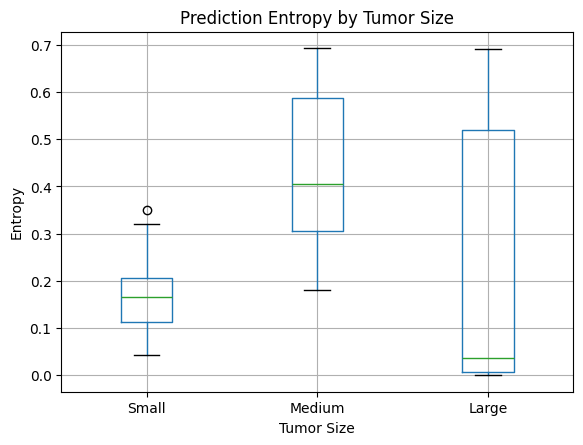

In [22]:
plt.figure(figsize=(6, 4))

df_uncertainty.boxplot(
    column="entropy",
    by="size_bucket",
    grid=False
)

plt.title("Prediction Entropy by Tumor Size")
plt.suptitle("")
plt.xlabel("Tumor Size")
plt.ylabel("Entropy")
plt.grid(True)

plt.savefig(
    FIGURES_DIR / "h5_entropy_by_size.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


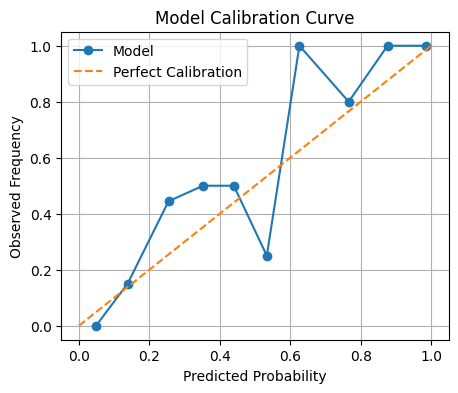

In [23]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
    y_test,
    y_prob,
    n_bins=10
)

plt.figure(figsize=(5, 4))

plt.plot(prob_pred, prob_true, marker="o", label="Model")
plt.plot([0, 1], [0, 1], "--", label="Perfect Calibration")

plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Model Calibration Curve")
plt.legend()
plt.grid(True)

plt.savefig(
    FIGURES_DIR / "h5_calibration_curve.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


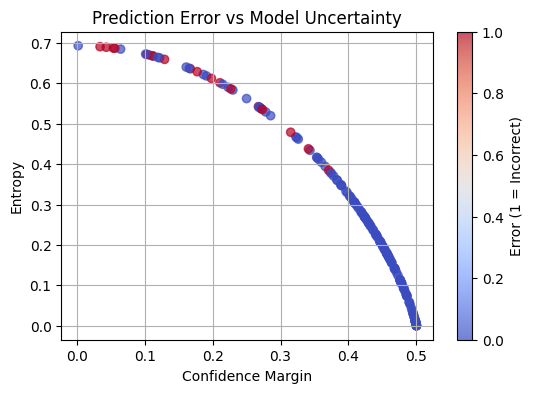

In [24]:
plt.figure(figsize=(6, 4))

scatter = plt.scatter(
    df_uncertainty["confidence_margin"],
    df_uncertainty["entropy"],
    c=df_uncertainty["error"],
    cmap="coolwarm",
    alpha=0.7
)

plt.xlabel("Confidence Margin")
plt.ylabel("Entropy")
plt.title("Prediction Error vs Model Uncertainty")

plt.colorbar(scatter, label="Error (1 = Incorrect)")
plt.grid(True)

plt.savefig(
    FIGURES_DIR / "h5_error_vs_uncertainty.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()
